In [1]:
%pip install --quiet --upgrade jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt, dates, ticker
import numpy as np
%load_ext sql
%matplotlib widget

pd.options.mode.copy_on_write = True

/tmp/ipykernel_2281/1204406387.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/flapkap/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [4]:
# set some matplotlib defaults
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator, MicrosecondLocator


# Set the global locator and formatter
plt.rcParams['date.autoformatter.microsecond'] = '%S.%f'  # Set the global format for microsecond level
plt.rcParams['date.autoformatter.second'] = '%H:%M:%S'  # Set the global format for second level
plt.rcParams['date.autoformatter.minute'] = '%H:%M'  # Set the global format for minute level
plt.rcParams['date.autoformatter.hour'] = '%Y-%m-%d %H:%M'  # Set the global format for hour level
plt.rcParams['date.autoformatter.day'] = '%Y-%m-%d %H:%M'  # Set the global format for day level
plt.rcParams['date.autoformatter.month'] = '%Y-%m-%d %H:%M'  # Set the global format for month level
plt.rcParams['date.autoformatter.year'] = '%Y-%m-%d %H:%M'  # Set the global format for year level


In [5]:
%sql duckdb:///./390850.duckdb

Connecting to 'duckdb:///./390850.duckdb'

In [6]:
%sqlcmd tables

Name
Gateway
Site
Node
Message
Trace
Radio
Power_Consumption
Downlink_Event_Error_Message
Join_Message
Content_Message


In [7]:
hej = %sql select message from Trace WHERE message LIKE 'TIMINGS>%'

In [8]:
hej["message"][0]

'TIMINGS> Loop: 0, Sync: 805 ms, Load: 30 ms, sensor init: 9 ms, env init: 0 ms, net init: 9427 ms, Collect: -1 ms, Exec: -1 ms, Send: 3412 ms, save config: 603 ms, Sleep: 10 s\n'

In [9]:
%sql nodes =<< select distinct * from Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board
0,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1


In [10]:

timestamps= %sql select timestamp from Power_Consumption 
#timestamps = timestamps["timestamp"].map(lambda x: x.isoformat())
%sql SUMMARIZE Power_Consumption

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,power_consumption_id,INTEGER,1,281265,283642,140633.0,81194.35606924923,70520,140926,210684,281265,0.0%
1,node_id,VARCHAR,70B3D57ED005EA59,70B3D57ED005EA59,1,None,None,None,None,None,281265,0.0%
2,timestamp,TIMESTAMP,2024-01-30 13:33:52.975361,2024-01-30 13:38:58.681077,278621,None,None,None,None,None,281265,0.0%
3,current,FLOAT,-0.001563,0.117748,1447,0.060140767226374375,0.014090325625451216,0.05223853141904061,0.0535234085916037,0.06097575132197949,281265,0.0%
4,voltage,FLOAT,1.6375,4.9325,321,4.855101496040024,0.11086267454559448,4.857500076293945,4.858839591758298,4.861249923706055,281265,0.0%
5,power,FLOAT,0.0,0.571401,453,0.2922684171419366,0.06837175761800036,0.25395588541875913,0.26076603898333783,0.2967285565296597,281265,0.0%


In [11]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from Power_Consumption group by node_id

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005EA59,281265,2024-01-30 13:33:52.975361,2024-01-30 13:38:58.681077


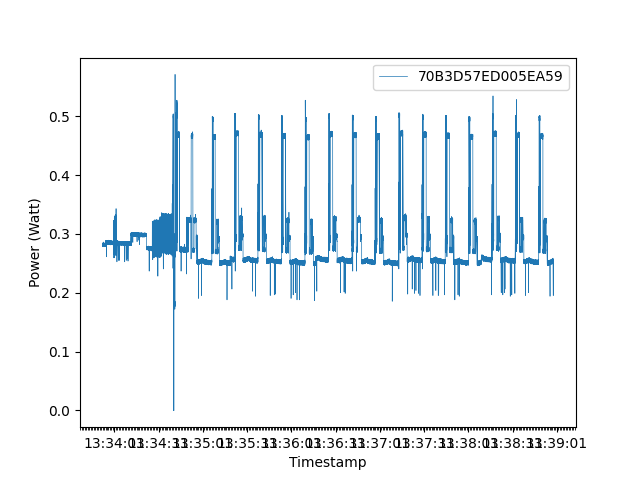

In [12]:
deveui = "70B3D57ED005EA59"

power_consumption= %sql select timestamp,power,current,voltage,node_id from Power_Consumption
power_consumption = power_consumption.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power_consumption.groupby("node_id")
plt.figure()
for node_id, group in groups:
    plt.plot(group.index, group["power"], label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))  # Set the major locator to display labels every 30 seconds
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=1))  # Set the minor locator to display labels at millisecond level
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S')) 
#plt.gca().xaxis.set_minor_formatter(DateFormatter('%S.%f'))  
plt.legend()
plt.show()

## finding sync signals

In [13]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

#diff of each group
power_consumption['power_diff'] = groups["power"].diff()
power_diff = power_consumption['power_diff']

# single node
power_single = power_consumption[(power_consumption["node_id"] ==deveui)]


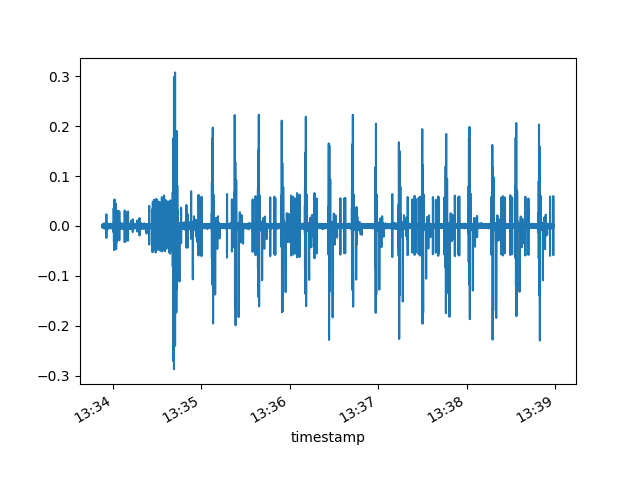

In [14]:
plt.figure()
power_diff.plot()
plt.show()

In [15]:
rising_edge = power_consumption[power_diff > 0.1].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_diff < -0.1].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges.head()

,power,current,voltage,node_id,power_diff,direction
timestamp,,,,,,
2024-01-30 13:34:40.755589,0.451749,0.093085,4.85625,70B3D57ED005EA59,0.175205,rising
2024-01-30 13:34:40.955578,0.391923,0.080753,4.85750,70B3D57ED005EA59,-0.107443,falling
2024-01-30 13:34:40.956646,0.274712,0.056408,4.86125,70B3D57ED005EA59,-0.117211,falling
2024-01-30 13:34:40.967509,0.000610,0.000171,3.02375,70B3D57ED005EA59,-0.270439,falling
2024-01-30 13:34:41.410970,0.300962,0.068617,4.64125,70B3D57ED005EA59,0.298520,rising


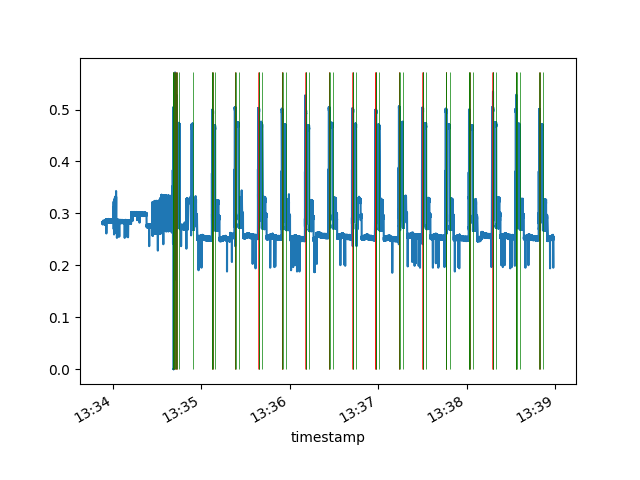

In [16]:
plt.figure()
power_single['power'].plot(label="power")
plt.vlines(edges[edges['direction'] == 'rising'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.vlines(edges[edges['direction'] == 'falling'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5)

plt.show()

In [17]:
# only keep edges where direction differ
edges['next_direction'] = edges['direction'].shift(-1)
edges['next_timestamp'] = edges.index.to_series().shift(-1)

# filter out edges that are too close to each other or too far apart. We add 10% tolerance
edges = edges[(edges['direction'] == "rising") & (edges['next_direction'] == "falling") & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=BLINK_HIGH_MS + (BLINK_HIGH_MS/10)))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=BLINK_HIGH_MS - (BLINK_HIGH_MS/10))))]
edges.head()


,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp
timestamp,,,,,,,,
2024-01-30 13:34:40.755589,0.451749,0.093085,4.85625,70B3D57ED005EA59,0.175205,rising,falling,2024-01-30 13:34:40.955578
2024-01-30 13:34:42.797833,0.504249,0.103756,4.85500,70B3D57ED005EA59,0.104390,rising,falling,2024-01-30 13:34:42.997822
2024-01-30 13:34:43.199977,0.465179,0.095820,4.85750,70B3D57ED005EA59,0.190467,rising,falling,2024-01-30 13:34:43.399967
2024-01-30 13:35:07.299571,0.447476,0.092157,4.85625,70B3D57ED005EA59,0.173985,rising,falling,2024-01-30 13:35:07.499560
2024-01-30 13:35:07.702783,0.495092,0.101900,4.85500,70B3D57ED005EA59,0.197182,rising,falling,2024-01-30 13:35:07.902803


In [18]:
## add counter to sync signals and add sync signal start and end times
edges.loc[:,'sync_num'] = range(len(edges)) 
edges.loc[:, 'sync_start'] = edges.index - pd.Timedelta(milliseconds=100)
edges.loc[:, 'sync_end'] = edges.next_timestamp + pd.Timedelta(milliseconds=100)
edges.head()

,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_num,sync_start,sync_end
timestamp,,,,,,,,,,,
2024-01-30 13:34:40.755589,0.451749,0.093085,4.85625,70B3D57ED005EA59,0.175205,rising,falling,2024-01-30 13:34:40.955578,0,2024-01-30 13:34:40.655589,2024-01-30 13:34:41.055578
2024-01-30 13:34:42.797833,0.504249,0.103756,4.85500,70B3D57ED005EA59,0.104390,rising,falling,2024-01-30 13:34:42.997822,1,2024-01-30 13:34:42.697833,2024-01-30 13:34:43.097822
2024-01-30 13:34:43.199977,0.465179,0.095820,4.85750,70B3D57ED005EA59,0.190467,rising,falling,2024-01-30 13:34:43.399967,2,2024-01-30 13:34:43.099977,2024-01-30 13:34:43.499967
2024-01-30 13:35:07.299571,0.447476,0.092157,4.85625,70B3D57ED005EA59,0.173985,rising,falling,2024-01-30 13:35:07.499560,3,2024-01-30 13:35:07.199571,2024-01-30 13:35:07.599560
2024-01-30 13:35:07.702783,0.495092,0.101900,4.85500,70B3D57ED005EA59,0.197182,rising,falling,2024-01-30 13:35:07.902803,4,2024-01-30 13:35:07.602783,2024-01-30 13:35:08.002803


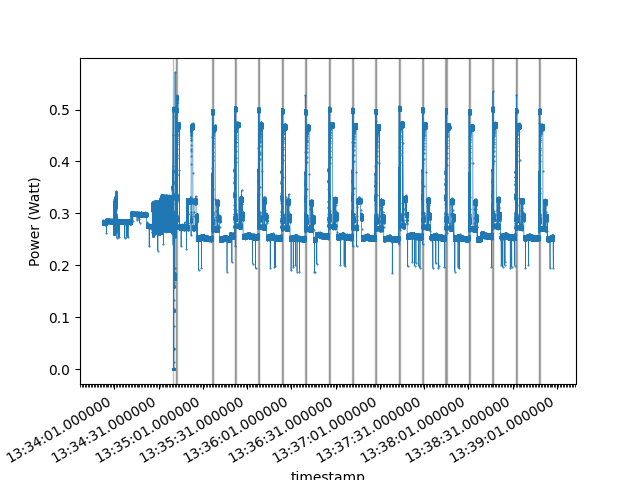

In [19]:
# visually verify sync signals
plt.figure()
power_single['power'].plot(style='.',markersize=1, label="power")
power_single['power'].plot(linewidth=0.5, color='tab:blue', label="power")
plt.ylabel("Power (Watt)")

## add sync signal indication
for row in edges.itertuples():
    plt.axvspan(row.sync_start, row.sync_end, color='grey', alpha=0.5, label="sync signal")

plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=1))

plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels

#plt.gca().xaxis.set_minor_locator(dates.AutoDateLocator(minticks=10, maxticks=20))

plt.gcf().autofmt_xdate()
plt.show()

In [20]:
# every loop starts with 2 sync signals right after each other
# find all sync signals where the next start is very close to previous end
edges['next_sync_start'] = edges['sync_start'].shift(-1)
edges['next_sync_end'] = edges['sync_end'].shift(-1)
loops = edges[(abs(edges['sync_end'] - edges['next_sync_start']) < pd.Timedelta(milliseconds=500))][['node_id', 'sync_start', 'next_sync_end']].copy()
loops.rename(columns={'sync_start': 'loop_signal_start', 'next_sync_end': 'loop_signal_end'}, inplace=True)
loops['loop_num'] = range(len(loops))
loops.head()

,node_id,loop_signal_start,loop_signal_end,loop_num
timestamp,,,,
2024-01-30 13:34:42.797833,70B3D57ED005EA59,2024-01-30 13:34:42.697833,2024-01-30 13:34:43.499967,0
2024-01-30 13:35:07.299571,70B3D57ED005EA59,2024-01-30 13:35:07.199571,2024-01-30 13:35:08.002803,1
2024-01-30 13:35:22.579111,70B3D57ED005EA59,2024-01-30 13:35:22.479111,2024-01-30 13:35:23.282343,2
2024-01-30 13:35:38.518364,70B3D57ED005EA59,2024-01-30 13:35:38.418364,2024-01-30 13:35:39.221566,3
2024-01-30 13:35:54.458716,70B3D57ED005EA59,2024-01-30 13:35:54.358716,2024-01-30 13:35:55.161949,4


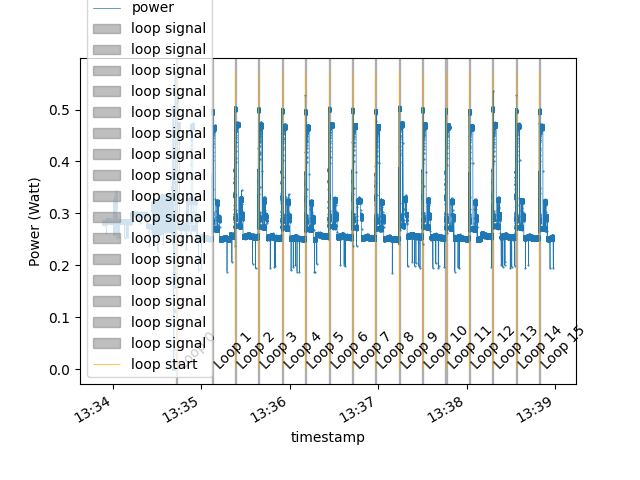

In [21]:
plt.figure()
power_single['power'].plot(style='.',markersize=1, label="power")
power_single['power'].plot(linewidth=0.5, color='tab:blue', label="power")
plt.ylabel("Power (Watt)")

## add sync signal indication
for row in loops.itertuples():
    plt.axvspan(row.loop_signal_start, row.loop_signal_end, color='tab:gray', alpha=0.5, label="loop signal")
    plt.text(row.Index, 0, f"Loop {row.loop_num}", rotation=45)
# plt.vlines(edges.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5, label="rising edge")
# plt.vlines(edges['next_timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5, label="falling edge")
plt.vlines(loops.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="orange", linewidth=0.5, label="loop start")

plt.legend()
plt.show()

In [22]:
# 'TIMINGS> Loop: 0, Sync: 806 ms, Load: 40 ms, sensor init: 10 ms, env init: 0 ms, net init: 5216 ms, Collect: -1 ms, Exec: -1 ms, Send: 5119 ms, save config: 2646 ms, Sleep: 9 s\n'
query = """
SELECT 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: (-?[0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: (-?[0-9]+)',1) as sync_time_ms,
    regexp_extract(message, '.*Load: (-?[0-9]+)',1) as load_time_ms,
    regexp_extract(message, '.*sensor init: (-?[0-9]+)',1) as sensor_init_time_ms,
    regexp_extract(message, '.*env init: (-?[0-9]+)',1) as env_init_time_ms,
    regexp_extract(message, '.*net init: (-?[0-9]+)',1) as net_init_time_ms,
    --regexp_extract(message, '.*Listen: (-?[0-9]+)',1) as listen_time_ms,
    regexp_extract(message, '.*Collect: (-?[0-9]+)',1) as collect_time_ms,
    regexp_extract(message, '.*Exec: (-?[0-9]+)',1) as exec_time_ms,
    regexp_extract(message, '.*Send: (-?[0-9]+)',1) as send_time_ms,
    regexp_extract(message, '.*save config: (-?[0-9]+)',1) as save_config_time_ms,
    regexp_extract(message, '.*Sleep: (-?[0-9]+)',1) as sleep_time_s
FROM Trace
WHERE message LIKE 'TIMINGS>%'
"""
timings = %sql {{query}}
timings.head()

,node_id,timestamp,loop_num,sync_time_ms,load_time_ms,sensor_init_time_ms,env_init_time_ms,net_init_time_ms,collect_time_ms,exec_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
0,70B3D57ED005EA59,2024-01-30 14:34:57.007999,0,805,30,9,0,9427,-1,-1,3412,603,10
1,70B3D57ED005EA59,2024-01-30 14:35:12.287071,1,806,25,9,0,56,-1,-1,3511,654,10
2,70B3D57ED005EA59,2024-01-30 14:35:28.227398,2,806,25,9,0,56,0,31,3960,680,10
3,70B3D57ED005EA59,2024-01-30 14:35:44.166537,3,806,25,9,0,56,0,31,3960,680,10
4,70B3D57ED005EA59,2024-01-30 14:36:00.106591,4,806,25,9,0,56,0,31,3960,680,10


In [23]:
# since duckdb return all columns as object we need to change types before we can merge
timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'sensor_init_time_ms', 'env_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']] = timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'sensor_init_time_ms', 'env_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num']).set_index('loop_signal_start')
loops.head()

,timestamp_x,node_id,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,sensor_init_time_ms,env_init_time_ms,net_init_time_ms,collect_time_ms,exec_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
loop_signal_start,,,,,,,,,,,,,,,
2024-01-30 13:34:42.697833,2024-01-30 13:34:42.797833,70B3D57ED005EA59,2024-01-30 13:34:43.499967,0,2024-01-30 14:34:57.007999,805,30,9,0,9427,-1,-1,3412,603,10
2024-01-30 13:35:07.199571,2024-01-30 13:35:07.299571,70B3D57ED005EA59,2024-01-30 13:35:08.002803,1,2024-01-30 14:35:12.287071,806,25,9,0,56,-1,-1,3511,654,10
2024-01-30 13:35:22.479111,2024-01-30 13:35:22.579111,70B3D57ED005EA59,2024-01-30 13:35:23.282343,2,2024-01-30 14:35:28.227398,806,25,9,0,56,0,31,3960,680,10
2024-01-30 13:35:38.418364,2024-01-30 13:35:38.518364,70B3D57ED005EA59,2024-01-30 13:35:39.221566,3,2024-01-30 14:35:44.166537,806,25,9,0,56,0,31,3960,680,10
2024-01-30 13:35:54.358716,2024-01-30 13:35:54.458716,70B3D57ED005EA59,2024-01-30 13:35:55.161949,4,2024-01-30 14:36:00.106591,806,25,9,0,56,0,31,3960,680,10


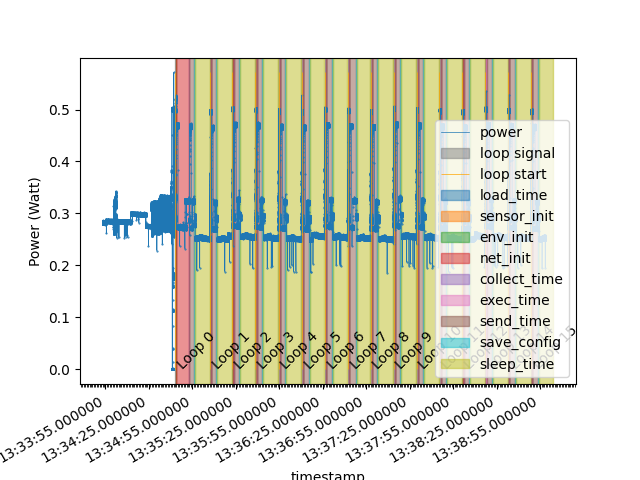

In [24]:

loops["start_time"] = loops.index
loops["sync_start"] = loops["start_time"]
loops["sync_end"] = loops["sync_start"] + pd.to_timedelta(loops["sync_time_ms"], unit="ms")
loops["load_start"] = loops["sync_end"]
loops["load_end"] = loops["load_start"] + pd.to_timedelta(loops["load_time_ms"], unit="ms")
loops["sensor_init_start"] = loops["load_end"]
loops["sensor_init_end"] = loops["sensor_init_start"] + pd.to_timedelta(loops["sensor_init_time_ms"], unit="ms")
loops["env_init_start"] = loops["sensor_init_end"]
loops["env_init_end"] = loops["env_init_start"] + pd.to_timedelta(loops["env_init_time_ms"], unit="ms")
loops["net_init_start"] = loops["env_init_end"]
loops["net_init_end"] = loops["net_init_start"] + pd.to_timedelta(loops["net_init_time_ms"], unit="ms")
loops["collect_time_start"] = loops["net_init_end"]
loops["collect_time_end"] = loops["collect_time_start"] +pd.to_timedelta(loops["collect_time_ms"], unit="ms")
loops["exec_start"] = loops["collect_time_end"]
loops["exec_end"] = loops["exec_start"] + pd.to_timedelta(loops["exec_time_ms"], unit="ms")
loops["send_start"] = loops["exec_end"]
loops["send_end"] = loops["send_start"] +pd.to_timedelta(loops["send_time_ms"], unit="ms")
loops["save_config_start"] = loops["send_end"]
loops["save_config_end"] = loops["save_config_start"] + pd.to_timedelta(loops["save_config_time_ms"], unit="ms")
loops["sleep_start"] = loops["save_config_end"]
loops["sleep_end"] = loops["sleep_start"] + pd.to_timedelta(loops["sleep_time_s"], unit="s")

loops.replace(-1,0) # remove -1 values. They show up if the time measurement is not available

for row in loops.itertuples():
    plt.axvspan(row.load_start, row.load_end, color='tab:blue', alpha=0.5, label="load_time")
    plt.axvspan(row.sensor_init_start, row.sensor_init_end, color='tab:orange', alpha=0.5, label="sensor_init")
    plt.axvspan(row.env_init_start, row.env_init_end, color='tab:green', alpha=0.5, label="env_init")
    plt.axvspan(row.net_init_start, row.net_init_end, color='tab:red', alpha=0.5, label="net_init")
    plt.axvspan(row.collect_time_start, row.collect_time_end, color='tab:purple', alpha=0.5, label="collect_time")
    plt.axvspan(row.exec_start, row.exec_end, color='tab:pink', alpha=0.5, label="exec_time")
    plt.axvspan(row.send_start, row.send_end, color='tab:brown', alpha=0.5, label="send_time")
    plt.axvspan(row.save_config_start, row.save_config_end, color='tab:cyan', alpha=0.5, label="save_config")
    plt.axvspan(row.sleep_start, row.sleep_end, color='tab:olive', alpha=0.5, label="sleep_time")
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=1))

plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels
plt.show()

## Add events if any

In [25]:
# get all relevant frame-events
%sql send_frame_start << select * from Trace WHERE message LIKE '%send frame%'
%sql send_frame_end << select * from Trace WHERE message LIKE '%Transmission completed%'
%sql receive_frame_start << select * from Trace WHERE message LIKE '%RX started%'
%sql receive_frame_end << select * from Trace WHERE message LIKE '%received something%'

In [26]:
#drop first row of send_frame_end and receive_frame_start since thats from the join procedure
send_frame_end = send_frame_end.iloc[1:]
receive_frame_start = receive_frame_start.iloc[1:]

# confirm the 2 pairs of start/end all have the same length
assert len(send_frame_start) == len(send_frame_end), f"send frame event mismatch. start {len(send_frame_start)}, end { len(send_frame_end)}"
assert len(receive_frame_start) == len(receive_frame_end), f"receive frame event mismatch  {len(receive_frame_start)}, end { len(receive_frame_end)}"

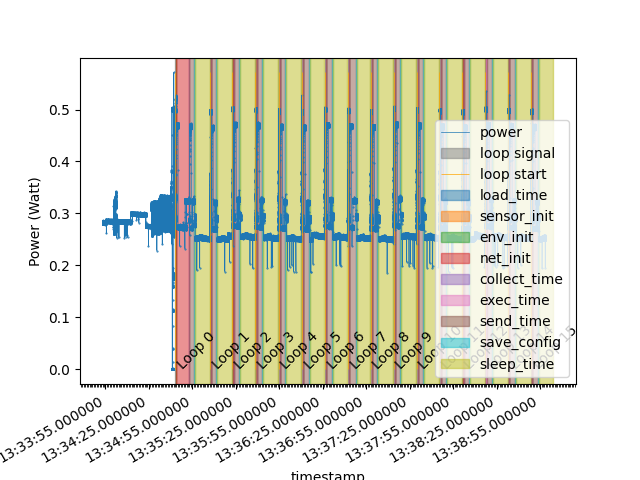

In [27]:
# add send and receive columns to plot

for send_start_row, send_end_row in zip(send_frame_start.itertuples(), send_frame_end.itertuples()):
    start_time = send_start_row.timestamp
    end_time = send_end_row.timestamp
    plt.axvspan(start_time, end_time, color='tab:pink', alpha=0.5, label="send_events")

for receive_frame_start, receive_frame_end in zip(receive_frame_start.itertuples(), receive_frame_end.itertuples()):
    start_time = receive_frame_start.timestamp
    end_time = receive_frame_end.timestamp
    plt.axvspan(start_time, end_time, color='tab:brown', alpha=0.5, label="receive_events")


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

In [28]:
%%sql
SELECT
    through_gateway,
    gateway_received_at,
    app_received_at,
    rssi,
    snr,
    bandwidth,
    frequency,
    consumed_airtime_s,
    spreading_factor,
    coding_rate,
    frame_counter,
    frame_port,
    frame_payload,
    from_base64(frame_payload) as decoded_payload,
    related_node,
    network_received_at
FROM
    Uplink_Message,
    Content_Message,
    Message 
WHERE
    Uplink_Message.uplink_message_id = Message.message_id AND
    Content_Message.content_message_id = Message.message_id

,through_gateway,gateway_received_at,app_received_at,rssi,snr,bandwidth,frequency,consumed_airtime_s,spreading_factor,coding_rate,frame_counter,frame_port,frame_payload,decoded_payload,related_node,network_received_at
0,gw-tetech-test,2024-01-30 14:34:54,2024-01-30 14:34:54.441515,-109,-4.0,125000,867300000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA59,2024-01-30 14:34:54.232495
1,iot-lab-saclay-gateway,2024-01-30 14:35:09,2024-01-30 14:35:09.658186,-33,13.0,125000,868100000,1.155072,SF12,4/5,1,2,PDM=,"[60, 51]",70B3D57ED005EA59,2024-01-30 14:35:09.453863
2,gw-tetech-test,2024-01-30 14:35:25,2024-01-30 14:35:25.478791,-121,NaN,125000,868100000,1.646592,SF12,4/5,2,2,CgwSAyD6EBIFVQAAAAA=,"[10, 12, 18, 3, 32, 250, 16, 18, 5, 85, 0, 0, ...",70B3D57ED005EA59,2024-01-30 14:35:25.268711
3,gw-tetech-test,2024-01-30 14:35:41,2024-01-30 14:35:41.424566,-117,0.0,125000,868100000,1.646592,SF12,4/5,3,2,CgwSAyCEERIFVQAAAAA=,"[10, 12, 18, 3, 32, 132, 17, 18, 5, 85, 0, 0, ...",70B3D57ED005EA59,2024-01-30 14:35:41.215367
4,iot-lab-saclay-gateway,2024-01-30 14:35:57,2024-01-30 14:35:57.430499,-36,14.0,125000,868100000,1.646592,SF12,4/5,4,2,CgwSAyD6EBIFVQAAAAA=,"[10, 12, 18, 3, 32, 250, 16, 18, 5, 85, 0, 0, ...",70B3D57ED005EA59,2024-01-30 14:35:57.225222
5,gw-tetech-test,2024-01-30 14:36:13,2024-01-30 14:36:13.299232,-120,-1.0,125000,868100000,1.646592,SF12,4/5,5,2,CgwSAyD6EBIFVQAAAAA=,"[10, 12, 18, 3, 32, 250, 16, 18, 5, 85, 0, 0, ...",70B3D57ED005EA59,2024-01-30 14:36:13.090122
6,gw-tetech-test,2024-01-30 14:36:29,2024-01-30 14:36:29.234395,-80,0.0,125000,868100000,1.646592,SF12,4/5,6,2,CgwSAyD6EBIFVQAAAAA=,"[10, 12, 18, 3, 32, 250, 16, 18, 5, 85, 0, 0, ...",70B3D57ED005EA59,2024-01-30 14:36:29.027502
7,iot-lab-saclay-gateway,2024-01-30 14:36:44,2024-01-30 14:36:45.318726,-103,0.0,125000,867100000,1.646592,SF12,4/5,7,2,CgwSAyCEERIFVQAAAAA=,"[10, 12, 18, 3, 32, 132, 17, 18, 5, 85, 0, 0, ...",70B3D57ED005EA59,2024-01-30 14:36:45.110756
8,gw-tetech-test,2024-01-30 14:37:00,2024-01-30 14:37:00.849225,-111,-2.0,125000,868300000,1.646592,SF12,4/5,8,2,CgwSAyCEERIFVQAAAAA=,"[10, 12, 18, 3, 32, 132, 17, 18, 5, 85, 0, 0, ...",70B3D57ED005EA59,2024-01-30 14:37:00.643398
9,iot-lab-saclay-gateway,2024-01-30 14:37:16,2024-01-30 14:37:16.864234,-101,-1.0,125000,867100000,1.646592,SF12,4/5,9,2,CgwSAyCEERIFVQAAAAA=,"[10, 12, 18, 3, 32, 132, 17, 18, 5, 85, 0, 0, ...",70B3D57ED005EA59,2024-01-30 14:37:16.655418


## Calculate Total Energy Consumed per region

In [29]:
def calc_energy_consumed(df: pd.DataFrame):
    # Assume df have columns "power" and index of "timestamp" type.
    # create a copy of the dataframe with only index and power
    if len(df) == 0:
        return 0
    power = df[["power"]]

    #power["power_diff"] = power.diff().shift(-1) #  current - previous, shifted one back so it becomes next - current. i.e. current + diff = next
    power["time_diff"] = abs(power.index.diff(-1)) # abs(next-current)
    us_per_s = 1_000_000
    power["time_diff_s"] = power["time_diff"].dt.microseconds / us_per_s # get timediff in fractions of a second
    power = power.drop(power.index[-1]) # drop last row since it has no next and therefore should be NaN
    return sum(power["power"] * power["time_diff_s"]) # returns the sum of power times fractions of a second. Since power is in W and time_diff_s is in seconds it is in W*s or J

calc_energy_consumed(power_single)
power_single.head()

,power,current,voltage,node_id,power_diff
timestamp,,,,,
2024-01-30 13:33:52.975361,0.281427,0.057873,4.86000,70B3D57ED005EA59,NaN
2024-01-30 13:33:52.976459,0.280817,0.057824,4.86000,70B3D57ED005EA59,-0.000610
2024-01-30 13:33:52.977527,0.280206,0.057629,4.86250,70B3D57ED005EA59,-0.000611
2024-01-30 13:33:52.978626,0.280206,0.057653,4.86125,70B3D57ED005EA59,0.000000
2024-01-30 13:33:52.979694,0.280817,0.057775,4.85750,70B3D57ED005EA59,0.000611


In [30]:
# loops contain the start and end times of each activity, so loop over loops and calculate the energy for each activity
def calc_energy_consumed_per_activity(series_loops: pd.Series) -> pd.Series:
    return pd.Series({
        "total": calc_energy_consumed(power_single.loc[series_loops.name:series_loops["sleep_end"]]),
        "loop signal": calc_energy_consumed(power_single.loc[series_loops.name:series_loops["loop_signal_end"]]),
        "total without loop signal": calc_energy_consumed(power_single.loc[series_loops["loop_signal_end"]:series_loops["sleep_end"]]),
        "load config": calc_energy_consumed(power_single.loc[series_loops["load_start"]:series_loops["load_end"]]),
        "sensor init": calc_energy_consumed(power_single.loc[series_loops["sensor_init_start"]:series_loops["sensor_init_end"]]),
        "env init": calc_energy_consumed(power_single.loc[series_loops["env_init_start"]:series_loops["env_init_end"]]),
        "net init": calc_energy_consumed(power_single.loc[series_loops["net_init_start"]:series_loops["net_init_end"]]),
        "sensor collect": calc_energy_consumed(power_single.loc[series_loops["collect_time_start"]:series_loops["collect_time_end"]]),
        "query execution": calc_energy_consumed(power_single.loc[series_loops["exec_start"]:series_loops["exec_end"]]),
        "send": calc_energy_consumed(power_single.loc[series_loops["send_start"]:series_loops["send_end"]]),
        "save config": calc_energy_consumed(power_single.loc[series_loops["save_config_start"]:series_loops["save_config_end"]]),
        "sleep": calc_energy_consumed(power_single.loc[series_loops["sleep_start"]:series_loops["sleep_end"]]),
    })
energy_consumed = loops.apply(calc_energy_consumed_per_activity, axis=1)
energy_consumed_summary = energy_consumed.describe()
energy_consumed_summary

,total,loop signal,total without loop signal,load config,sensor init,env init,net init,sensor collect,query execution,send,save config,sleep
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.0,16.000000,16.0,16.000000,16.000000,16.000000,16.000000
mean,4.600048,0.309813,4.289923,0.007017,0.002183,0.0,0.202858,0.0,0.007421,1.423463,0.201647,2.442824
std,0.797195,0.001849,0.796445,0.000405,0.000020,0.0,0.747536,0.0,0.002899,0.105612,0.008181,0.357241
min,3.081158,0.307370,2.772865,0.006839,0.002155,0.0,0.015812,0.0,0.000000,1.224552,0.174269,1.126827
25%,4.508001,0.307964,4.199307,0.006866,0.002165,0.0,0.015869,0.0,0.008388,1.409419,0.202817,2.529070
50%,4.529626,0.309848,4.218985,0.006930,0.002190,0.0,0.015984,0.0,0.008444,1.429388,0.204322,2.545008
75%,4.556719,0.311509,4.245939,0.006962,0.002192,0.0,0.016094,0.0,0.008530,1.452756,0.205308,2.561028
max,7.257396,0.312881,6.945320,0.008523,0.002228,0.0,3.006117,0.0,0.008793,1.710398,0.206874,2.570603


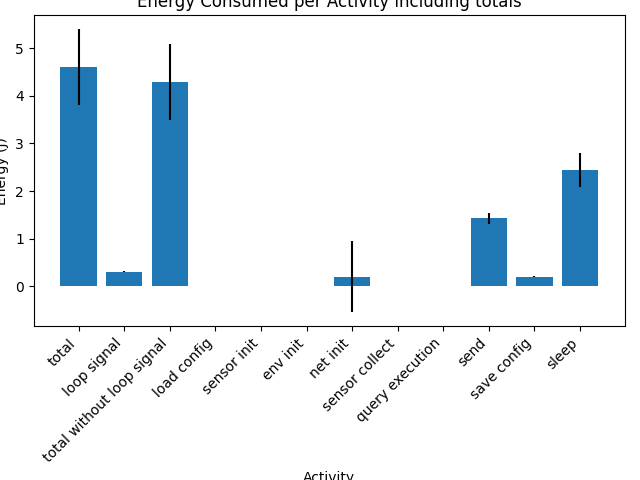

In [31]:
# plot barchart with stddev error bars
plt.figure()
plt.bar(energy_consumed_summary.columns, energy_consumed_summary.loc["mean"], yerr=energy_consumed_summary.loc["std"])
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity including totals")
plt.show()

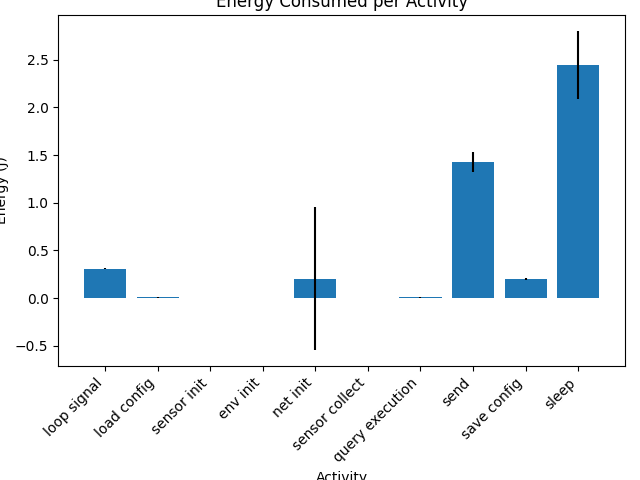

In [32]:
# plot barchart without totals 
plt.figure()
energy_consumed_summary_no_totals = energy_consumed_summary.drop(["total", "total without loop signal"], axis=1)
plt.bar(energy_consumed_summary_no_totals.columns, energy_consumed_summary_no_totals.loc["mean"], yerr=energy_consumed_summary_no_totals.loc["std"])
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity")
plt.show()